# Homework 2
### ASTROINFORMATICS
https://github.com/astromundus/astroinfo2018


## Problem

Using the functions shown in class (and copied below), examine the accuracy of various ways to estimate the flux of an object. In particular:

1. Generate a few (say, three) simulated image of a star using the `simulatedImage` function for different seed values, and visualize them using plotCutout. Run `psfPhot` and `apPhot` on the results of each image, and print the estimated flux.

2. Write a function `centerPhot` that uses the value of the central pixel as the estimator of the total magnitude of the object. What is the result? Is that estimator biased?

3. Generate a thousand different simulated images using `simulatedImage`, and compute `centerPhot`, `psfPhot`, and `apPhot` for each simulated image. Plot the histogram of estimates for each (three histogram in total), as well as the mean (using `np.average`) and standard deviation (with `np.std`).

4. Some of the estimators above will be (very) biased, and standard deviations (which are the measure of the accuracy of the estimate) are not directly comparable. To make them comparable, multiply each of them by `Atrue/Amean` (where `Amean` is the mean computed above). This mimics what would happen if we were to remove the bias by calibrating with standard stars. What do you observe about the recalibrated widths of the histograms? Which one is the narrowest, and why?

## Solution

In [1]:
%matplotlib inline

from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=15, usetex=True)

import numpy as np
import math
import matplotlib.pyplot as plt

def makePSF(shape, x0, y0, sigmaPSF):
    # Add a (Gaussian) PSF of width sigmaPSF, centered on (x0, y0)
    xx = np.arange(shape[0]) - shape[0]/2.+0.5
    yy = np.arange(shape[1]) - shape[1]/2.+0.5
    
    r = np.sqrt((xx[:, None]-x0)**2 + (yy[None, :]-y0)**2)
    psf = np.exp(-r**2./2./sigmaPSF) / (2*math.pi*sigmaPSF)
    return psf

def plotCutout(img, title = None, clabel='$counts$', xlabel='x (pixels)', ylabel='y (pixels)', loc=None, fig=None):
    """Make a nice looking plot of a small image"""
    if loc is None:
        fig, ax = plt.subplots(figsize=(8,8))
        fig.subplots_adjust(right=0.8, bottom=0.34)
    else:
        ax = fig.add_subplot(loc)

    # coordinate of the edge (assuming a square image)
    xe = img.shape[0] / 2.

    if title is None:
        title = "min = %.0f, max=%.0f" % (img.min(), img.max())
    
    ax.set_title(title, fontsize=14)
    plt.imshow(img, origin='lower', interpolation='nearest',
           extent=(-xe, xe, -xe, xe),
           cmap=plt.cm.binary, aspect='auto')
    plt.clim(200, 400)
    plt.colorbar().set_label(clabel)

    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

In [2]:
Atrue = 1000.0    # the source count normalization
xdim = 15         # width of the image
ydim = 15         # height of the image
muXtrue = 0.0     # source x centroid 
muYtrue = 0.0     # source y centroid
sigmaPSF = 1.5    # in pixels, corresponds to seeing = 1.5*0.2*2.355 = 0.7 arcsec for LSST (0.2" pix)
skyBg = 250.0     # sky background

In [3]:
def simulatedImage(seed):
    np.random.seed(seed)

    image = np.zeros((xdim, ydim))
    image = Atrue * makePSF(image.shape, 0, 0, sigmaPSF)
    image += skyBg
    image = np.random.poisson(image)
    
    return image

### Task 1

A_ap(r=3) = 8398.0
A_ML = 1178.0 with chi^2/dof = 1.11
seed=20


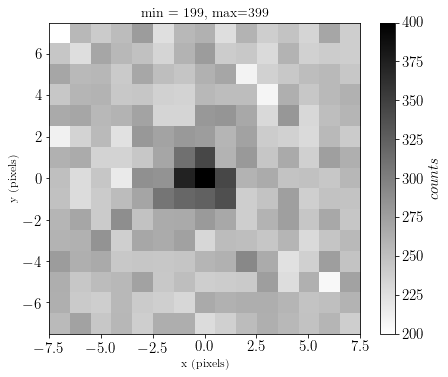

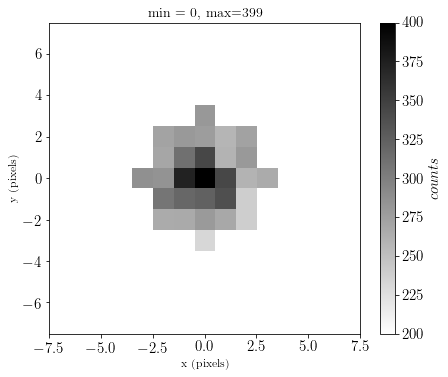

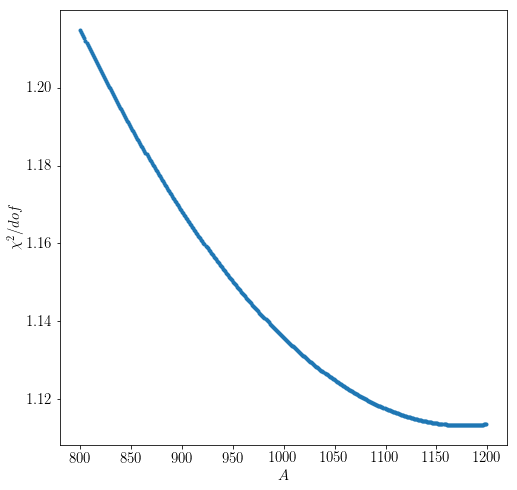

In [4]:
#Plot image with background for seed value of 20 
image = simulatedImage(20)
plotCutout(image)

def apPhot(image, r = 3, x0=0, y0=0):
    xx = np.arange(image.shape[0]) - image.shape[0]/2.+0.5
    yy = np.arange(image.shape[1]) - image.shape[1]/2.+0.5
    
    rpix = np.sqrt((xx[:, None]-x0)**2 + (yy[None, :]-y0)**2)
    apPhotImage = image[:]
    apPhotImage[rpix > r] = 0

    return apPhotImage.sum(), apPhotImage

image = simulatedImage(20)

r = 3

count, apPhotImage = apPhot(image, r)

print('A_ap(r=%.0f) = %.1f' % (r, count))
plotCutout(apPhotImage)

def psfPhot(image, Amin, Amax):
    """ Perform PSF photometry with a PSF=N(x=0,y=0,\sigma=sigmaNoise)"""
    # Estimate the noise in the image
    sigmaNoise = np.sqrt(image)

    # Subtract the background (we assume we've estimated it somehow)
    image = image - skyBg

    testA = np.arange(Amin, Amax)
    chi2dof = np.empty(testA.shape)
    best = (np.nan, np.inf)
    psf = makePSF(image.shape, 0, 0, sigmaPSF)
    for i, A in enumerate(testA):
        model = A*psf
        chi2 = np.sum(((image-model)/sigmaNoise)**2)
        chi2dof[i] = chi2 / (image.size - 1)
        if chi2dof[i] < best[1]:
            best = (A, chi2dof[i])
    return best, testA, chi2dof

image = simulatedImage(20)

((bestA, bestChi2dof), testA, chi2dof) = psfPhot(image, Atrue - 200, Atrue + 200)
print('A_ML = %.1f with chi^2/dof = %.2f' % (bestA, bestChi2dof))
print('seed=20')
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(testA, chi2dof, '.')
ax.set_xlabel(r"$A$")
ax.set_ylabel(r"$\chi^2/dof$");

A_ap(r=3) = 8087.0
A_ML = 879.0 with chi^2/dof = 0.98
seed=100


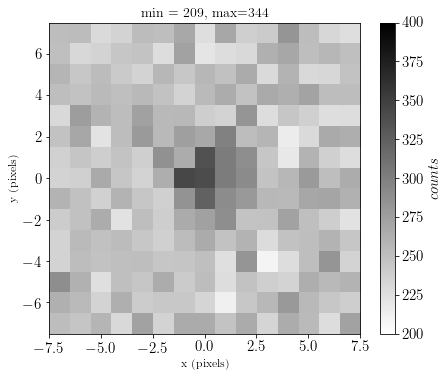

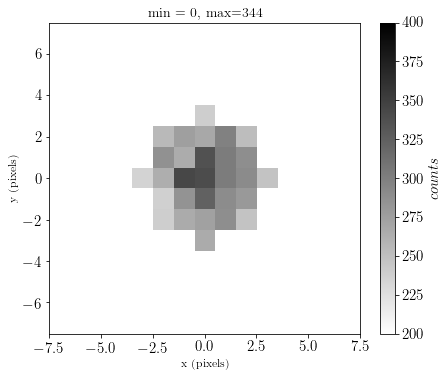

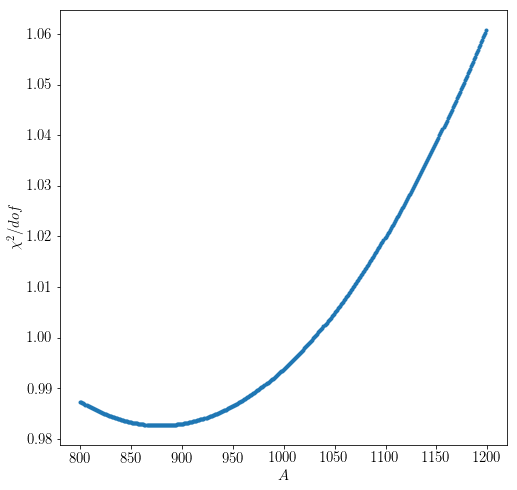

In [5]:
#Plot image with background for seed value of 100 
image = simulatedImage(100)
plotCutout(image)

def apPhot(image, r = 3, x0=0, y0=0):
    xx = np.arange(image.shape[0]) - image.shape[0]/2.+0.5
    yy = np.arange(image.shape[1]) - image.shape[1]/2.+0.5
    
    rpix = np.sqrt((xx[:, None]-x0)**2 + (yy[None, :]-y0)**2)
    apPhotImage = image[:]
    apPhotImage[rpix > r] = 0

    return apPhotImage.sum(), apPhotImage

image = simulatedImage(100)

r = 3

count, apPhotImage = apPhot(image, r)

print('A_ap(r=%.0f) = %.1f' % (r, count))
plotCutout(apPhotImage)

def psfPhot(image, Amin, Amax):
    """ Perform PSF photometry with a PSF=N(x=0,y=0,\sigma=sigmaNoise)"""
    # Estimate the noise in the image
    sigmaNoise = np.sqrt(image)

    # Subtract the background (we assume we've estimated it somehow)
    image = image - skyBg

    testA = np.arange(Amin, Amax)
    chi2dof = np.empty(testA.shape)
    best = (np.nan, np.inf)
    psf = makePSF(image.shape, 0, 0, sigmaPSF)
    for i, A in enumerate(testA):
        model = A*psf
        chi2 = np.sum(((image-model)/sigmaNoise)**2)
        chi2dof[i] = chi2 / (image.size - 1)
        if chi2dof[i] < best[1]:
            best = (A, chi2dof[i])
    return best, testA, chi2dof

image = simulatedImage(100)

((bestA, bestChi2dof), testA, chi2dof) = psfPhot(image, Atrue - 200, Atrue + 200)
print("A_ML = %.1f with chi^2/dof = %.2f" % (bestA, bestChi2dof))
print('seed=100')
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(testA, chi2dof, '.')
ax.set_xlabel(r"$A$")
ax.set_ylabel(r"$\chi^2/dof$");

A_ap(r=3) = 8207.0
A_ML = 1084.0 with chi^2/dof = 1.09
seed=2000


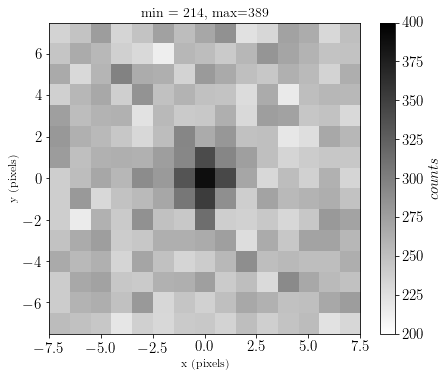

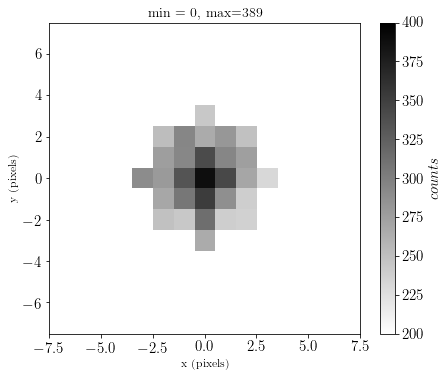

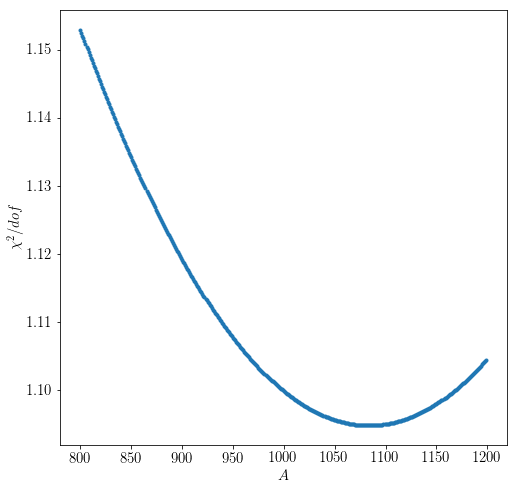

In [6]:
#Plot image with background for seed value of 2000
image = simulatedImage(2000)
plotCutout(image)

def apPhot(image, r = 3, x0=0, y0=0):
    xx = np.arange(image.shape[0]) - image.shape[0]/2.+0.5
    yy = np.arange(image.shape[1]) - image.shape[1]/2.+0.5
    
    rpix = np.sqrt((xx[:, None]-x0)**2 + (yy[None, :]-y0)**2)
    apPhotImage = image[:]
    apPhotImage[rpix > r] = 0

    return apPhotImage.sum(), apPhotImage

image = simulatedImage(2000)

r = 3

count, apPhotImage = apPhot(image, r)

print('A_ap(r=%.0f) = %.1f' % (r, count))
plotCutout(apPhotImage)

def psfPhot(image, Amin, Amax):
    """ Perform PSF photometry with a PSF=N(x=0,y=0,\sigma=sigmaNoise)"""
    # Estimate the noise in the image
    sigmaNoise = np.sqrt(image)

    # Subtract the background (we assume we've estimated it somehow)
    image = image - skyBg

    testA = np.arange(Amin, Amax)
    chi2dof = np.empty(testA.shape)
    best = (np.nan, np.inf)
    psf = makePSF(image.shape, 0, 0, sigmaPSF)
    for i, A in enumerate(testA):
        model = A*psf
        chi2 = np.sum(((image-model)/sigmaNoise)**2)
        chi2dof[i] = chi2 / (image.size - 1)
        if chi2dof[i] < best[1]:
            best = (A, chi2dof[i])
    return best, testA, chi2dof

image = simulatedImage(2000)

((bestA, bestChi2dof), testA, chi2dof) = psfPhot(image, Atrue - 200, Atrue + 200)
print("A_ML = %.1f with chi^2/dof = %.2f" % (bestA, bestChi2dof))
print('seed=2000')
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(testA, chi2dof, '.')
ax.set_xlabel(r"$A$")
ax.set_ylabel(r"$\chi^2/dof$");

### Task 2

In [7]:
#estimate flux using the value of the central pixel
image = simulatedImage(20)
def centerPhot(image):
    image = image - skyBg #remove sky background
    flux=image[7][7]
    return flux
print('Flux (seed=20) = %s'%centerPhot(image))

image = simulatedImage(100)
def centerPhot(image):
    image = image - skyBg
    flux=image[7][7]
    return flux
print('Flux (seed=100) = %s'%centerPhot(image))

image = simulatedImage(2000)
def centerPhot(image):
    image = image - skyBg
    flux=image[7][7]
    return flux
print('Flux (seed=2000) = %s'%centerPhot(image))

Flux (seed=20) = 149.0
Flux (seed=100) = 90.0
Flux (seed=2000) = 139.0


The difference between the flux estimated using only central pixel and using the method from the Task 1 is caused by the fact that here we are taking only the value of the central pixel, so as a result we have only one specified element from the image array. At the same time using the method in Task 1 in the defined function we are taking into account all pixels and it is the reason of the noticeable difference in the obtained values, because the sum of the surrounding the central pixels also gives significant contribution to the value of the total flux. This estimator is biased because we are using only one selected value which we are assuming as a true vale, but the real flux can differ significantly from the flux from the central pixel.

### Task 3 / 4

In [8]:
def simulatedImage(seed): #define function to simulate image
    np.random.seed(seed)

    image = np.zeros((xdim, ydim))
    image = Atrue * makePSF(image.shape, 0, 0, sigmaPSF)
    image += skyBg
    image = np.random.poisson(image)
    
    return image

def apPhot(image, r = 3, x0=0, y0=0): #define apPhot function
    xx = np.arange(image.shape[0]) - image.shape[0]/2.+0.5
    yy = np.arange(image.shape[1]) - image.shape[1]/2.+0.5
    
    rpix = np.sqrt((xx[:, None]-x0)**2 + (yy[None, :]-y0)**2)
    apPhotImage = image - skyBg
    apPhotImage[rpix > r] = 0

    return apPhotImage.sum()

def psfPhot(image, Amin = 600, Amax = 1400): #define psfPhot function
    sigmaNoise = np.sqrt(image)

    image = image - skyBg
    
    sigmaNoise = np.sqrt(skyBg)

    testA = np.arange(Amin, Amax)
    chi2dof = np.empty(testA.shape)
    best = (np.nan, np.inf)
    psf = makePSF(image.shape, 0, 0, sigmaPSF)
    for i, A in enumerate(testA):
        model = A*psf
        chi2 = np.sum(((image-model)/sigmaNoise)**2)
        chi2dof[i] = chi2 / (image.size - 1)
        if chi2dof[i] < best[1]:
            best = (A, chi2dof[i])
    return best[0]

def centerPhot(image): #define function to estimate flux from the central pixel
    image = image - skyBg
    flux=image[7][7]
    return flux

im1=[] #set empty array to store image values
apphot1=[] #set empty array to store apPhot flux values
psfphot1=[] #set empty array to store psfPhot flux values
central1=[] #set empty array to store flux values from the central pixel
for seed in range(10,1010,10): #generate loop to get 1000 images, seed values are defined as [n]=[n-1]+10 starting 
#from the seed=10 up to the seed=1010 
    image = simulatedImage(seed)
    aph=apPhot(image, r = 3, x0=0, y0=0)
    psf=psfPhot(image, Amin = 600, Amax = 1400)
    cent=centerPhot(image)
    im1.append(image) #add elements to the empty array
    im=np.hstack(im1) #stack the filled array
    apphot1.append(aph)
    apphot=np.hstack(apphot1)
    psfphot1.append(psf)
    psfphot=np.hstack(psfphot1)
    central1.append(cent)
    central=np.hstack(central1)

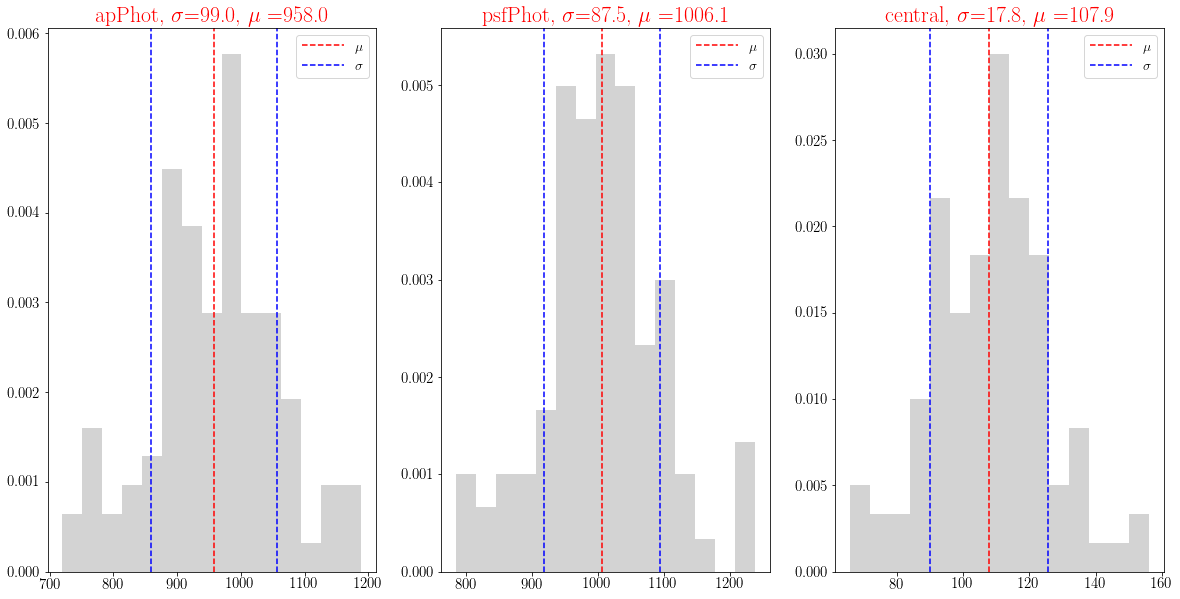

In [9]:
sigmaap = np.std(apphot) #find standard deviation value of the flux data constrained from 1000 images by apPhot method
averageap=np.average(apphot) #find average value of the flux data constrained from 1000 images by apPhot method
sigmapsf = np.std(psfphot) #find standard deviation value of the flux data constrained from 1000 images by psfPhot method
averagepsf=np.average(psfphot) #find average value of the flux data constrained from 1000 images by psfPhot method
sigmacent = np.std(central) #find standard deviation value of the flux data constrained from 1000 images via the central pixel method
averagecent=np.average(central) #find average value of the flux data constrained from 1000 images via the central pixel method
num_bins = 15
fig = plt.figure(figsize=(20, 10))

fig.subplots_adjust(wspace=0.2)

ax = fig.add_subplot(131)
nap, binsap, patchesap = ax.hist(apphot, num_bins, normed=True, color='lightgrey')
plt.axvline(averageap, color='r', linestyle='dashed', label='$\mu$')
plt.axvline(averageap-sigmaap, color='b', linestyle='dashed', label='$\sigma$')
plt.axvline(averageap+sigmaap, color='b', linestyle='dashed')
ax.set_title('apPhot, $\sigma$=%.1f, $\mu$ =%.1f'%(sigmaap,averageap), color='red',fontsize=22)
plt.legend(fontsize=14)

ax = fig.add_subplot(132)
npsf, binspsf, patchespsf = ax.hist(psfphot, num_bins, normed=True, color='lightgrey')
plt.axvline(averagepsf, color='r', linestyle='dashed', label='$\mu$')
plt.axvline(averagepsf-sigmapsf, color='b', linestyle='dashed', label='$\sigma$')
plt.axvline(averagepsf+sigmapsf, color='b', linestyle='dashed')
ax.set_title('psfPhot, $\sigma$=%.1f, $\mu$ =%.1f'%(sigmapsf,averagepsf), color='red',fontsize=22)
plt.legend(fontsize=14)

ax = fig.add_subplot(133)
ncent, binscent, patchescent = ax.hist(central, num_bins, normed=True, color='lightgrey')
plt.axvline(averagecent, color='r', linestyle='dashed', label='$\mu$')
plt.axvline(averagecent-sigmacent, color='b', linestyle='dashed', label='$\sigma$')
plt.axvline(averagecent+sigmacent, color='b', linestyle='dashed')
ax.set_title('central, $\sigma$=%.1f, $\mu$ =%.1f'%(sigmacent,averagecent), color='red',fontsize=22)
plt.legend(fontsize=14)

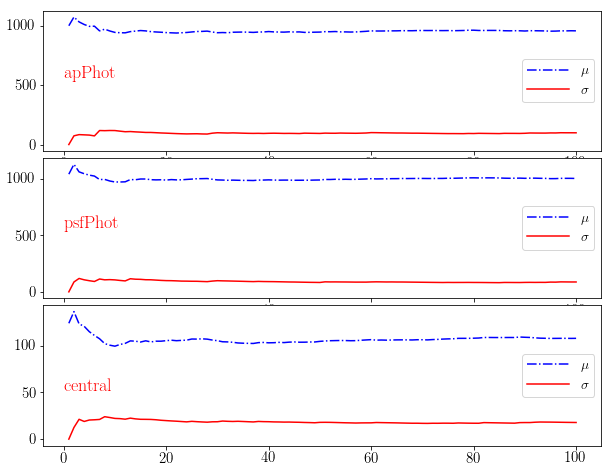

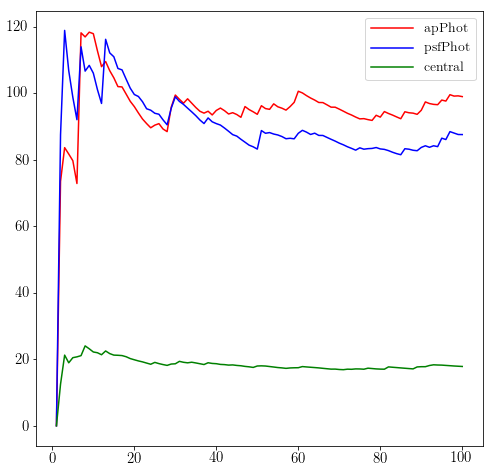

In [10]:
#Define average and standard deviation values for each point in the constrained data sets for each of the applied methods
#for flux estimation
Nrange1 = np.arange(1, len(apphot)+ 1)
average1 = [np.average(apphot[:N]) for N in Nrange1]
stdv1=[np.std(apphot[:N]) for N in Nrange1]
Nrange2 = np.arange(1, len(psfphot) + 1)
average2 = [np.average(psfphot[:N]) for N in Nrange2]
stdv2=[np.std(psfphot[:N]) for N in Nrange2]
Nrange3 = np.arange(1, len(central) + 1)
average3 = [np.average(central[:N]) for N in Nrange3]
stdv3=[np.std(central[:N]) for N in Nrange3]

fig = plt.figure(figsize=(10, 8))
fig.subplots_adjust(hspace=0.05)

#Draw average values and standard deviations for each of the applied method for flux estimation on separate plots
ax = fig.add_subplot(311)
ax.plot(Nrange1, average1, '-.b', label='$\mu$')
ax.plot(Nrange1, stdv1, '-r', label='$\sigma$')
plt.text(0, 550, r'apPhot',fontsize=18,color='red')
ax.legend(fontsize=14)
ax = fig.add_subplot(312)
ax.plot(Nrange2, average2, '-.b', label='$\mu$')
ax.plot(Nrange2, stdv2, '-r', label='$\sigma$')
plt.text(0, 550, r'psfPhot',fontsize=18, color='red')
ax.legend(fontsize=14)
ax = fig.add_subplot(313)
ax.plot(Nrange3, average3, '-.b', label='$\mu$')
ax.plot(Nrange3, stdv3, '-r', label='$\sigma$')
plt.text(0, 50, r'central',fontsize=18,color='red')
ax.legend(fontsize=14)

#Draw all three standard deviations data on the same plot to compare them
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(Nrange1, stdv1, '-r', label='apPhot')
ax.plot(Nrange2, stdv2, '-b', label='psfPhot')
ax.plot(Nrange3, stdv3, '-g', label='central')
ax.legend(fontsize=14)

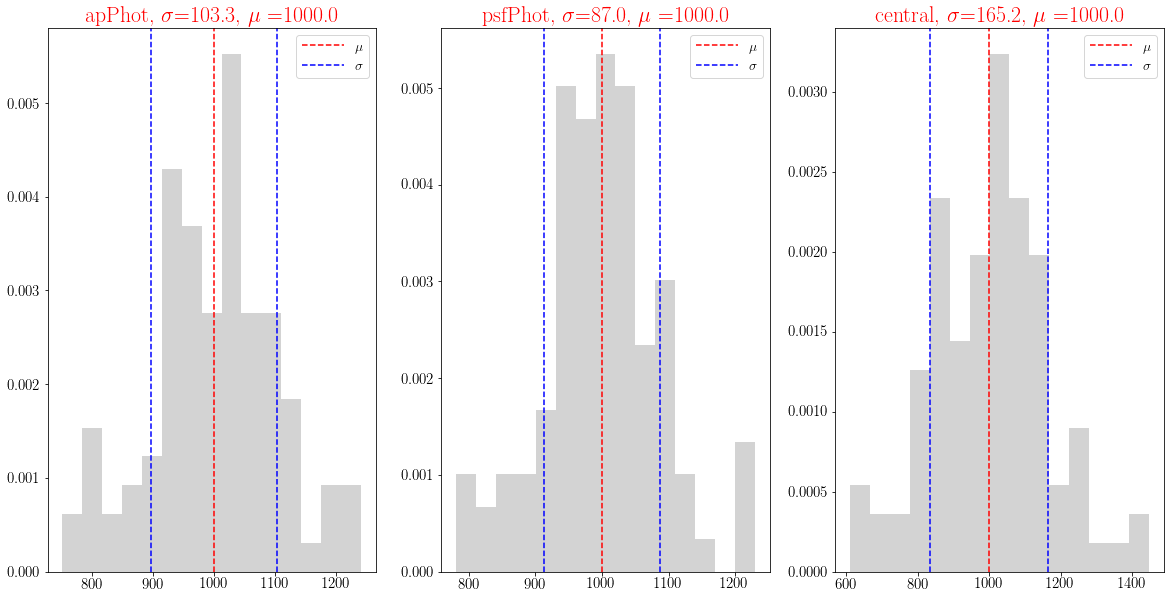

In [11]:
Atrue=1000

#remove the bias by multiplying the estimators with the Atrue/Amean
apphot=apphot*Atrue/averageap
psfphot=psfphot*Atrue/averagepsf
central=central*Atrue/averagecent

sigmaap = np.std(apphot)
averageap=np.average(apphot)
sigmapsf = np.std(psfphot) 
averagepsf=np.average(psfphot)
sigmacent = np.std(central)
averagecent=np.average(central)
num_bins = 15
fig = plt.figure(figsize=(20, 10))

fig.subplots_adjust(wspace=0.2)

ax = fig.add_subplot(131)
nap, binsap, patchesap = ax.hist(apphot, num_bins, normed=True, color='lightgrey')
plt.axvline(averageap, color='r', linestyle='dashed', label='$\mu$')
plt.axvline(averageap-sigmaap, color='b', linestyle='dashed', label='$\sigma$')
plt.axvline(averageap+sigmaap, color='b', linestyle='dashed')
ax.set_title('apPhot, $\sigma$=%.1f, $\mu$ =%.1f'%(sigmaap,averageap), color='red',fontsize=22)
plt.legend(fontsize=14)

ax = fig.add_subplot(132)
npsf, binspsf, patchespsf = ax.hist(psfphot, num_bins, normed=True, color='lightgrey')
plt.axvline(averagepsf, color='r', linestyle='dashed', label='$\mu$')
plt.axvline(averagepsf-sigmapsf, color='b', linestyle='dashed', label='$\sigma$')
plt.axvline(averagepsf+sigmapsf, color='b', linestyle='dashed')
ax.set_title('psfPhot, $\sigma$=%.1f, $\mu$ =%.1f'%(sigmapsf,averagepsf), color='red',fontsize=22)
plt.legend(fontsize=14)

ax = fig.add_subplot(133)
ncent, binscent, patchescent = ax.hist(central, num_bins, normed=True, color='lightgrey')
plt.axvline(averagecent, color='r', linestyle='dashed', label='$\mu$')
plt.axvline(averagecent-sigmacent, color='b', linestyle='dashed', label='$\sigma$')
plt.axvline(averagecent+sigmacent, color='b', linestyle='dashed')
ax.set_title('central, $\sigma$=%.1f, $\mu$ =%.1f'%(sigmacent,averagecent), color='red',fontsize=22)
plt.legend(fontsize=14)

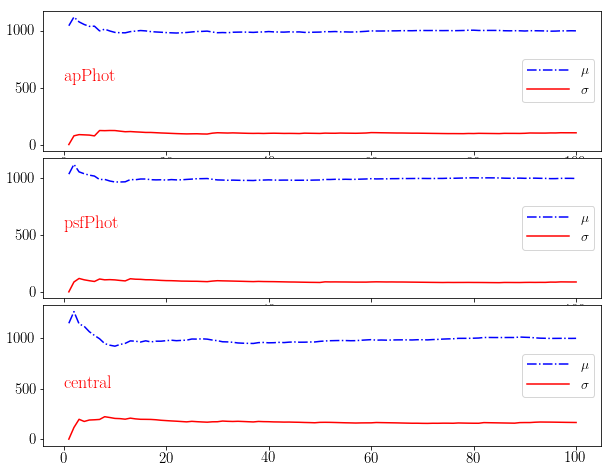

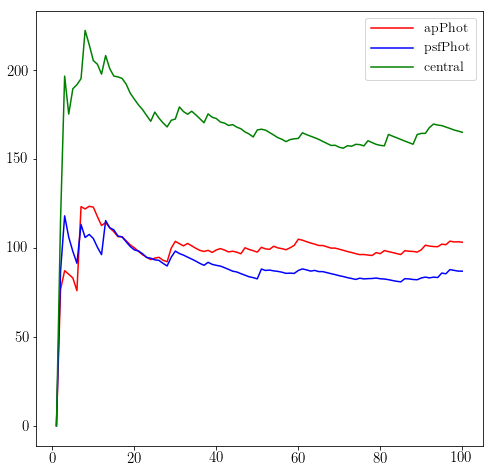

In [12]:
#Define average and standard deviation values for each point in the constrained data sets for each of the applied methods
#for flux estimation
Nrange1 = np.arange(1, len(apphot)+ 1)
average1 = [np.average(apphot[:N]) for N in Nrange1]
stdv1=[np.std(apphot[:N]) for N in Nrange1]
Nrange2 = np.arange(1, len(psfphot) + 1)
average2 = [np.average(psfphot[:N]) for N in Nrange2]
stdv2=[np.std(psfphot[:N]) for N in Nrange2]
Nrange3 = np.arange(1, len(central) + 1)
average3 = [np.average(central[:N]) for N in Nrange3]
stdv3=[np.std(central[:N]) for N in Nrange3]

fig = plt.figure(figsize=(10, 8))
fig.subplots_adjust(hspace=0.05)

#Draw average values and standard deviations for each of the applied method for flux estimation on separate plots
ax = fig.add_subplot(311)
ax.plot(Nrange1, average1, '-.b', label='$\mu$')
ax.plot(Nrange1, stdv1, '-r', label='$\sigma$')
plt.text(0, 550, r'apPhot',fontsize=18,color='red')
ax.legend(fontsize=14)
ax = fig.add_subplot(312)
ax.plot(Nrange2, average2, '-.b', label='$\mu$')
ax.plot(Nrange2, stdv2, '-r', label='$\sigma$')
plt.text(0, 550, r'psfPhot',fontsize=18, color='red')
ax.legend(fontsize=14)
ax = fig.add_subplot(313)
ax.plot(Nrange3, average3, '-.b', label='$\mu$')
ax.plot(Nrange3, stdv3, '-r', label='$\sigma$')
plt.text(0, 500, r'central',fontsize=18,color='red')
ax.legend(fontsize=14)

#Draw all three standard deviations data on the same plot to compare them
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(Nrange1, stdv1, '-r', label='apPhot')
ax.plot(Nrange2, stdv2, '-b', label='psfPhot')
ax.plot(Nrange3, stdv3, '-g', label='central')
ax.legend(fontsize=14)

As we can see, the standard deviations for the fluxes obtained using apPhot and psfPhot functions have very close values in cases when bias is note removed and when it is removed by the multiplication of the biased standard deviation value by `Atrue/Amean`. For the apPhot method the biased standard deviation is 99 while after the multiplication by `Atrue/Amean` it is 103.3, so the value of the standard deviation increased after the bias removing procedure. For the psfPhot method the biased standard deviation is 87.5 while after the multiplication by `Atrue/Amean` it is 87.0, so the value of the standard deviation remains almost the same showing only a slight decrease. And for the central pixel method the biased standard deviation is 17.8, which is very small value. However, after the bias substraction via the multiplucation of the standard deviation by `Atrue/Amean` we have the standard deviation value of 165.2. So, as it was expected, the flux estimation using the central pixel method produces the largest bias which means that the central pixel method gives the least correct value of the total flux. At the same, we can notice that there is almost no changes in the standard deviation value in the case of psfPhot method, so it can be assumed to generate the less bias and provide the best flux estimation.